In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime as dt

import yfinance as yf

import itertools

In [2]:
# EXTRACT DATA

def extract_price_level(df: pd.DataFrame, price: str = "Close") -> pd.DataFrame:

    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("`df.columns` must be a MultiIndex with levels ['Price','Ticker']")
    out = df.xs(price, axis=1, level="Price")
    return out.reindex(sorted(out.columns), axis=1)


def data_YFinance(tickers: list[str], start: str, end: str, interval: str = "1d", price: str = "Close") -> pd.DataFrame:
 
    # 1) Download into a MultiIndex‐column DataFrame: (Price, Ticker)
    raw = yf.download(tickers=tickers, start=start, end=end, interval=interval, group_by="column",
                      auto_adjust=False, threads=True, progress=False)

    # 2) Extract only the requested price‐level
    price_df = extract_price_level(raw, price)

    return price_df

In [3]:
def strategy_performance(df: pd.DataFrame, strat_ret_col: str = 'strategy_ret', ret_col: str = 'returns',
                         trading_days: int = 252, risk_free: float = 0.0, plot: bool = False, pairs: bool = False
                        ) -> tuple[pd.DataFrame, pd.DataFrame]:

    # Compute performance
    perf_df = pd.DataFrame(index=df.index)
    perf_df['strategy_log_ret'] = df[strat_ret_col]
    perf_df['cum_factor'] = np.exp(perf_df['strategy_log_ret'].cumsum())
    perf_df['cum_return'] = perf_df['cum_factor'] - 1
    perf_df['high_watermark'] = perf_df['cum_factor'].cummax()
    perf_df['drawdown'] = (perf_df['cum_factor'] - perf_df['high_watermark']) / perf_df['high_watermark']
    max_dd = perf_df['drawdown'].min()

    # Scalar metrics
    mean_lr = perf_df['strategy_log_ret'].mean()
    std_lr = perf_df['strategy_log_ret'].std()
    total_ret = perf_df['cum_return'].iloc[-1]
    ann_return = mean_lr * trading_days
    ann_std = std_lr * np.sqrt(trading_days)
    daily_rf = risk_free / trading_days
    ann_sharpe = ((mean_lr - daily_rf) / std_lr) * np.sqrt(trading_days) if std_lr else np.nan

    metrics_df = pd.DataFrame({
        'Value': [total_ret, ann_return, ann_std, ann_sharpe, max_dd]
    }, index=[
        'Strategy Cum Ret',
        'Annualized Return',
        'Annualized Std',
        'Annualized Sharpe',
        'Max Drawdown'
    ])

    # Plotting
    if plot:
        # 1) Strategy vs Buy & Hold (only if single-asset mode, i.e. pairs=False)
        if not pairs and ret_col in df:
            bh_growth = (1 + df[ret_col].fillna(0)).cumprod()
            fig, ax = plt.subplots(figsize=(14, 4))
            ax.plot(perf_df.index, perf_df['cum_factor'], label='Strategy', color='green', linewidth=1.5)
            ax.plot(bh_growth.index, bh_growth, label='Buy & Hold', color='blue', linewidth=1.5)
            ax.set_title("Strategy vs Buy & Hold Growth", fontsize=14, color='darkred')
            ax.set_ylabel("Growth Factor", fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            ax.legend()
            ax.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

        # 2) Growth Index & High Watermark
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.plot(perf_df.index, perf_df['cum_factor'], label='Growth Index', color='green', linewidth=1.5)
        ax.plot(perf_df.index, perf_df['high_watermark'], label='High Watermark',
                color='purple', linestyle='--', linewidth=1.5)
        ax.set_title("Growth Index & High Watermark", fontsize=14, color='darkred')
        ax.set_ylabel("Growth Factor", fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # 3) Drawdown Over Time
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.plot(perf_df.index, perf_df['drawdown'], label='Drawdown', color='red', linewidth=1.5)
        ax.axhline(0, color='black', linestyle=':', linewidth=1)
        ax.set_title("Drawdown Over Time", fontsize=14, color='darkred')
        ax.set_ylabel("Drawdown", fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return perf_df, metrics_df

In [4]:
crypto_tickers = ['BTC-USD', 'ETH-USD', 'DOT-USD', 'LTC-USD', 'ADA-USD', 'SOL-USD', 'XRP-USD']

US_tickers = ['SPY', 'AAPL', 'MSFT']

global_tickers =  ["^GDAXI", "NKE", "0941.HK"] 

start = dt.datetime(2021, 4, 1)
end = dt.datetime.now()

In [5]:
Crypto_data = data_YFinance(crypto_tickers, start, end)
US_data = data_YFinance(US_tickers, start, end)
Global_data = data_YFinance(global_tickers, start, end)

## **1. Trend following**

### 1.1. Simple Moving Averages

In [8]:
def SMA_crossover_strategy(df: pd.DataFrame, price_col: str, short: int = 5,long: int = 20,
                           plot: bool = False, plot_window: int | None = None) -> pd.DataFrame:

    df = df.copy()
    price = df[price_col]

    # 1) log returns
    df['returns']    = np.log(price / price.shift(1))

    # 2) moving averages
    df['ma_short']   = price.rolling(window=short, min_periods=short).mean()
    df['ma_long']    = price.rolling(window=long, min_periods=long).mean()

    # 3) raw signal (same-day)
    df['signal']     = 0
    df.loc[df['ma_short'] > df['ma_long'], 'signal'] =  1
    df.loc[df['ma_short'] < df['ma_long'], 'signal'] = -1

    # 4) next-day position
    df['position']   = df['signal'].shift(1).fillna(0).astype(int)

    # 5) strategy returns
    df['strategy_ret'] = df['position'] * df['returns']

    # 6) plotting
    if plot:
        data_to_plot = df if plot_window is None else df.tail(plot_window)
        fig, ax = plt.subplots(figsize=(12,5))

        # price and SMAs
        ax.plot(data_to_plot.index, data_to_plot[price_col],
                label=price_col, linewidth=1.2, color='black')
        ax.plot(data_to_plot.index, data_to_plot['ma_short'],
                label=f"SMA {short}", linewidth=1, color='orange')
        ax.plot(data_to_plot.index, data_to_plot['ma_long'],
                label=f"SMA {long}",  linewidth=1, color='blue')

        # shading long/short regimes
        ymin, ymax = data_to_plot[price_col].min(), data_to_plot[price_col].max()
        ax.fill_between(data_to_plot.index, ymin, ymax,
                        where=(data_to_plot['position'] > 0),
                        facecolor='green', alpha=0.4, label='Long')
        ax.fill_between(data_to_plot.index, ymin, ymax,
                        where=(data_to_plot['position'] < 0),
                        facecolor='red', alpha=0.4, label='Short')

        ax.set_title(f"SMA Crossover ({short}/{long}) on {price_col}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        ax.legend(loc='upper left')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return df

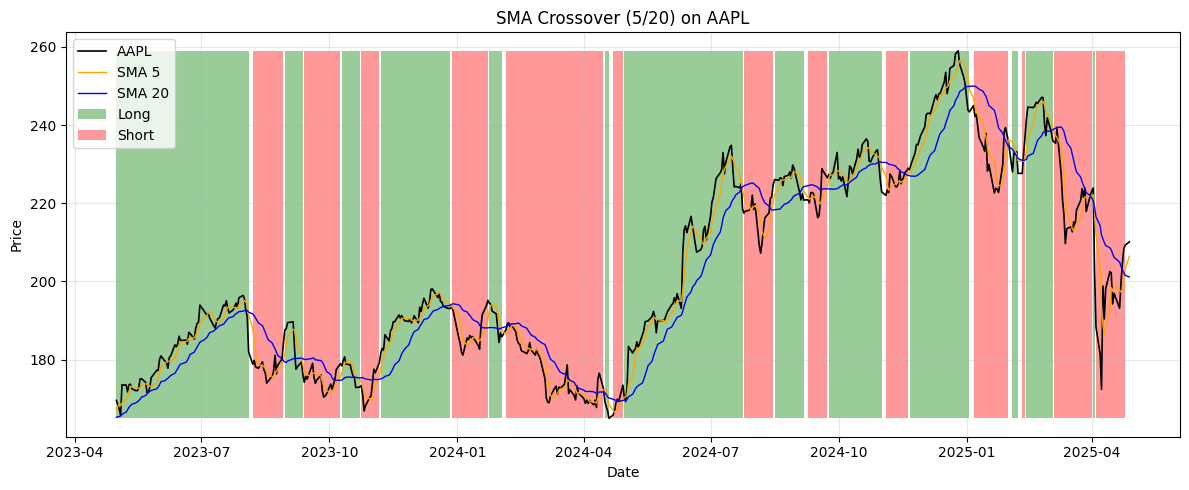

In [9]:
SMA_AAPL = SMA_crossover_strategy(US_data[['AAPL']], price_col = 'AAPL', plot = True, plot_window = 500)

In [10]:
SMA_AAPL.tail(3)

Ticker,AAPL,returns,ma_short,ma_long,signal,position,strategy_ret
Date,,,,,,,
2025-04-24,208.369995,0.018258,200.570001,202.280502,-1,-1,-0.018258
2025-04-25,209.279999,0.004358,203.030002,201.552001,1,-1,-0.004358
2025-04-28,210.139999,0.004101,206.426001,201.164001,1,1,0.004101


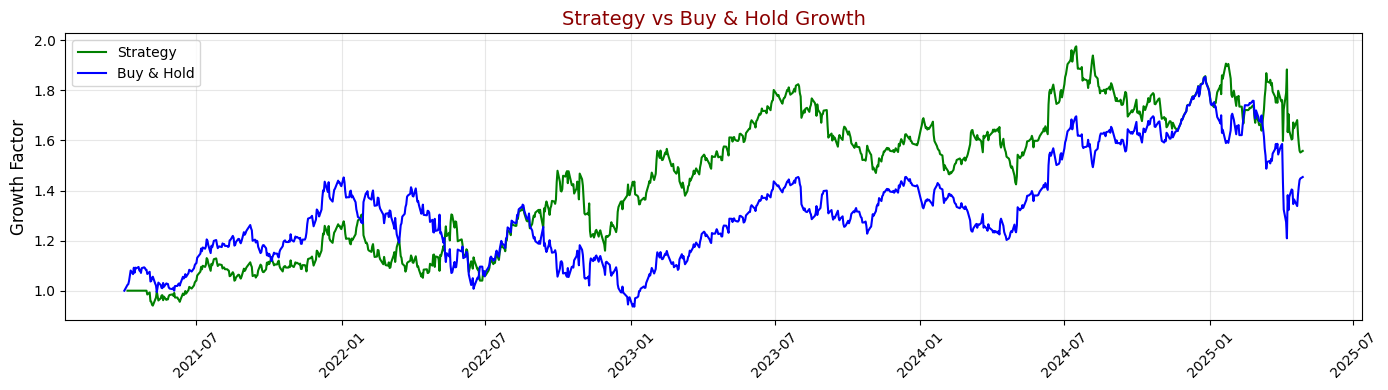

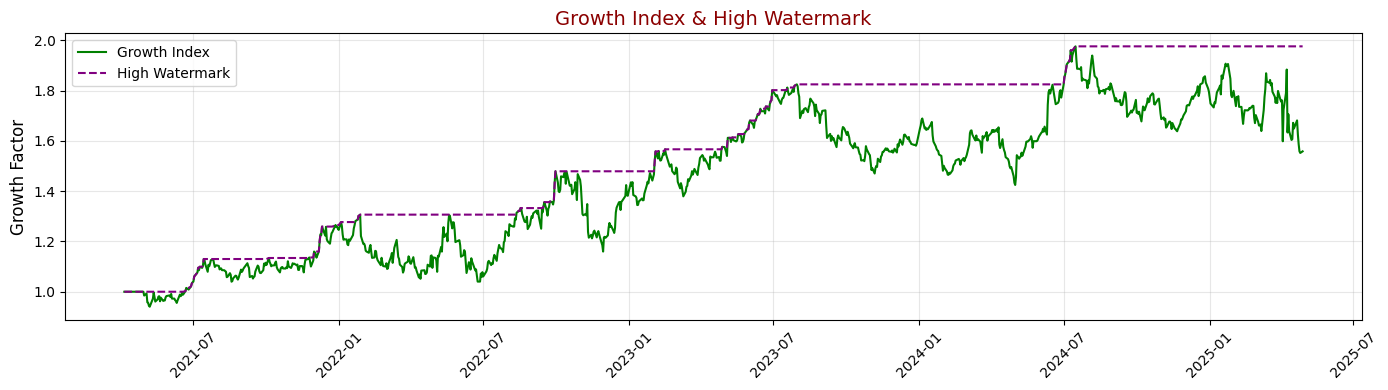

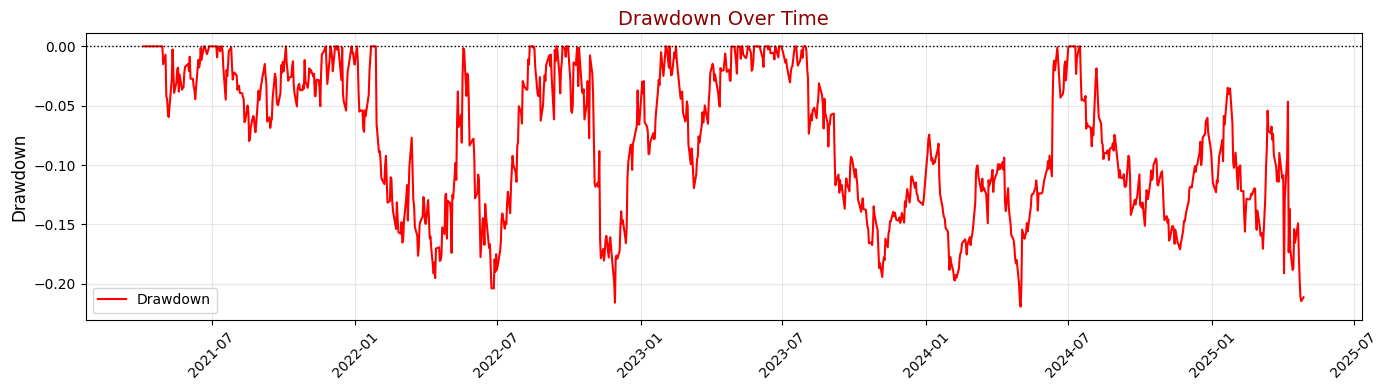

In [11]:
perf_SMA_AAPL, metrics_SMA_AAPL = strategy_performance(SMA_AAPL, trading_days=252, plot=True, pairs = False)

In [12]:
metrics_SMA_AAPL

,Value
Strategy Cum Ret,0.558273
Annualized Return,0.109375
Annualized Std,0.280775
Annualized Sharpe,0.389548
Max Drawdown,-0.219281


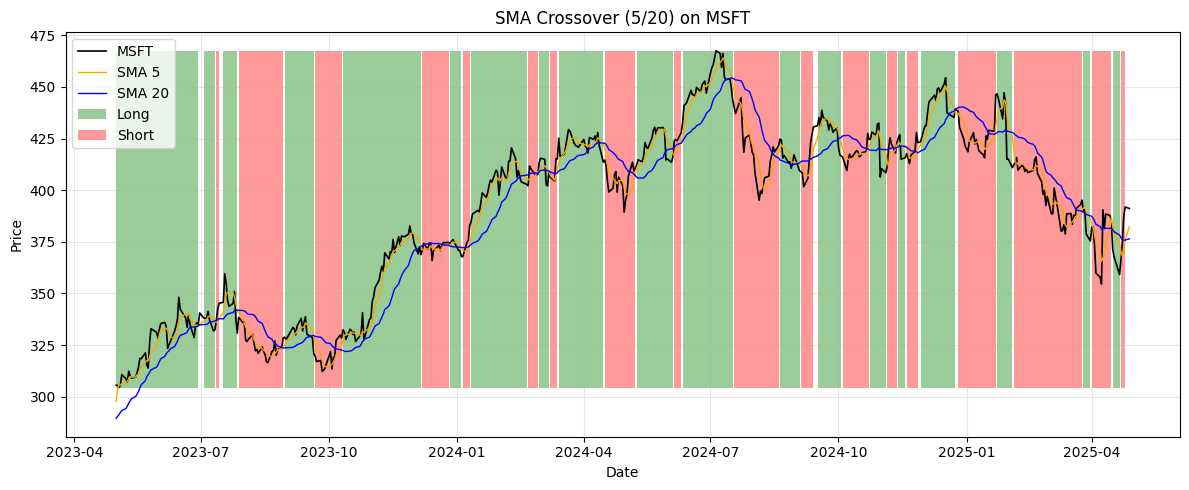

In [13]:
SMA_MSFT = SMA_crossover_strategy(US_data[['MSFT']], price_col = 'MSFT', plot = True, plot_window = 500)

In [14]:
SMA_MSFT.tail(3)

Ticker,MSFT,returns,ma_short,ma_long,signal,position,strategy_ret
Date,,,,,,,
2025-04-24,387.299988,0.033901,371.082001,375.765999,-1,-1,-0.033901
2025-04-25,391.850006,0.011680,375.896002,375.829500,1,-1,-0.011680
2025-04-28,391.160004,-0.001762,382.304004,376.447501,1,1,-0.001762


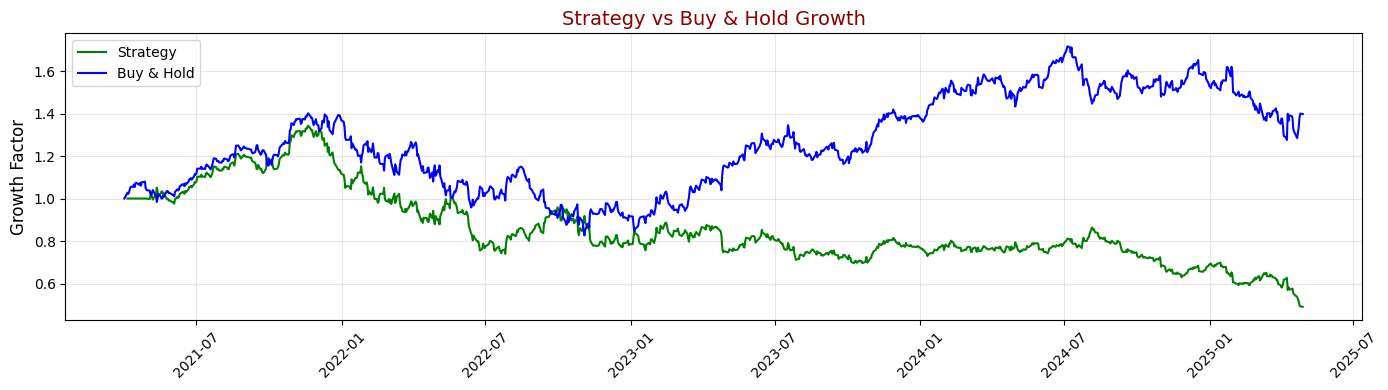

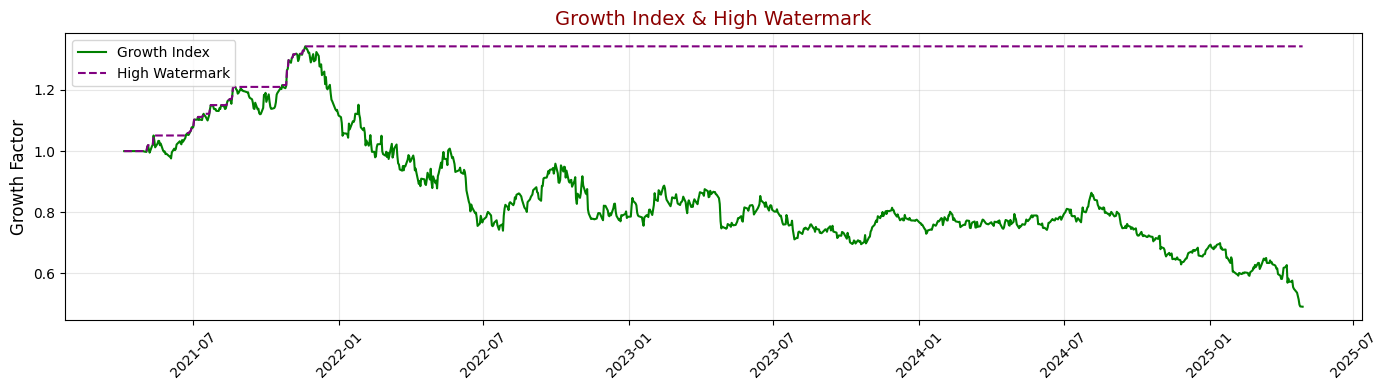

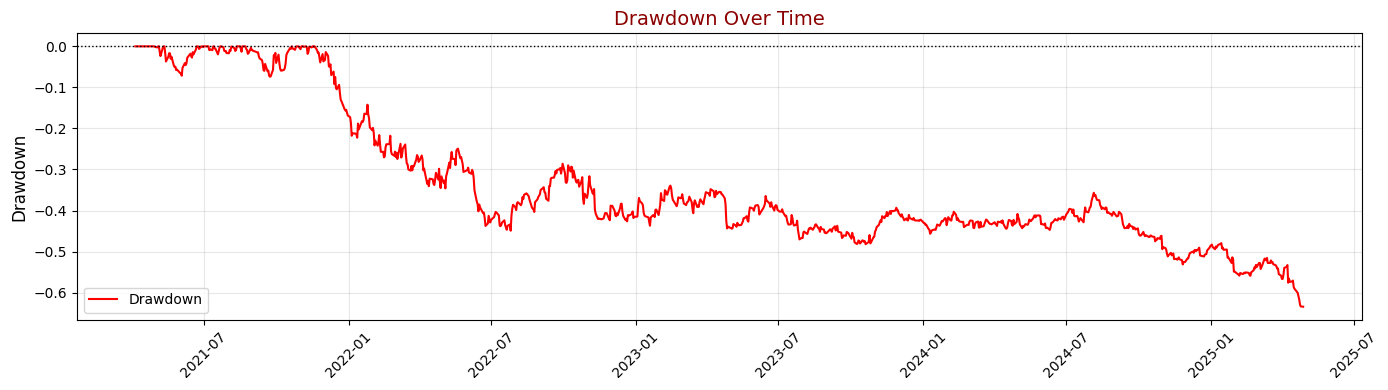

In [15]:
perf_SMA_MSFT, metrics_SMA_MSFT = strategy_performance(SMA_MSFT, trading_days=252, plot=True, pairs=False)

In [16]:
metrics_SMA_MSFT

,Value
Strategy Cum Ret,-0.508944
Annualized Return,-0.175364
Annualized Std,0.265120
Annualized Sharpe,-0.661451
Max Drawdown,-0.634273


### 1.2. RSI

In [18]:
def RSI_strategy(df: pd.DataFrame, price_col: str = 'Close', window: int = 14, 
                 lower_threshold: float = 30, upper_threshold: float = 70, plot: bool = False, 
                 plot_window: int | None = None) -> pd.DataFrame:

    df = df.copy()
    price = df[price_col]

    # 1) Compute Wilder RSI via EMA
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - 100/(1 + rs)

    # 2) Generate signals based purely on zones
    df['signal'] = 0
    df.loc[df['rsi'] < lower_threshold, 'signal'] =  1
    df.loc[df['rsi'] > upper_threshold, 'signal'] = -1

    # 3) Next-day position & returns/PnL
    df['position'] = df['signal'].shift(1).fillna(0).astype(int)
    df['returns'] = np.log(price / price.shift(1))
    df['strategy_ret'] = df['position'] * df['returns']

    # 4) Optional plotting
    if plot:
        data_to_plot = df if plot_window is None else df.tail(plot_window)
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), sharex=True)

        # Price with shaded regimes
        ax1.plot(data_to_plot.index, data_to_plot[price_col], label=price_col, color='black')
        ymin, ymax = data_to_plot[price_col].min(), data_to_plot[price_col].max()
        ax1.fill_between(data_to_plot.index, ymin, ymax,
                         where=(data_to_plot['position']>0),
                         facecolor='green', alpha=0.3, label='Long')
        ax1.fill_between(data_to_plot.index, ymin, ymax,
                         where=(data_to_plot['position']<0),
                         facecolor='red', alpha=0.3, label='Short')
        ax1.set_title(f"{price_col} Price & RSI({window}) Positions")
        ax1.set_ylabel("Price")
        ax1.legend(loc='upper left')
        ax1.grid(alpha=0.3)

        # RSI plot with thresholds
        ax2.plot(data_to_plot.index, data_to_plot['rsi'], label='RSI', color='blue')
        ax2.axhline(lower_threshold, color='green', linestyle='--', label=f'Long Threshold ({lower_threshold})')
        ax2.axhline(upper_threshold, color='red', linestyle='--', label=f'Short Threshold ({upper_threshold})')
        ax2.set_title("RSI")
        ax2.set_ylabel("RSI")
        ax2.set_xlabel("Date")
        ax2.legend(loc='upper left')
        ax2.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    return df

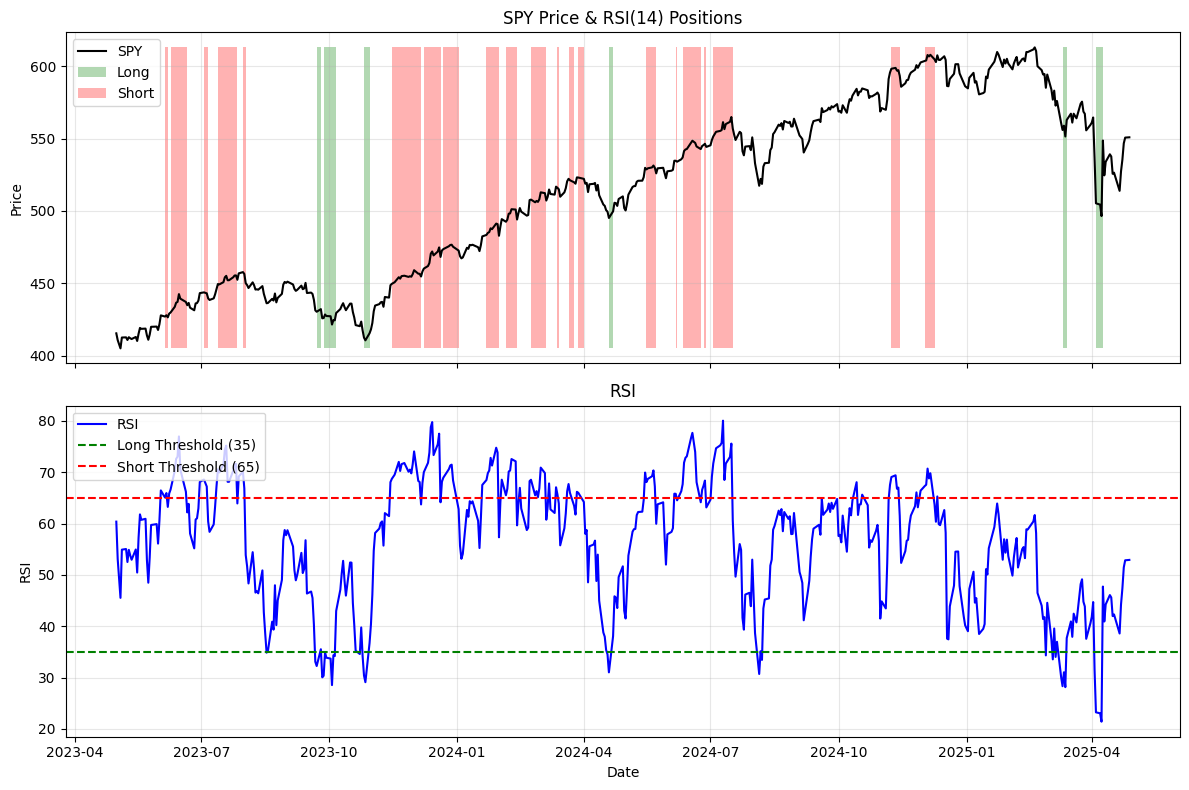

In [19]:
RSI_SPY = RSI_strategy(US_data[['SPY']], price_col='SPY', window=14, lower_threshold=35, upper_threshold=65, 
                       plot=True, plot_window = 500)

In [20]:
RSI_SPY.tail(3)

Ticker,SPY,rsi,signal,position,returns,strategy_ret
Date,,,,,,
2025-04-24,546.690002,51.464157,0,0,0.020830,0.0
2025-04-25,550.640015,52.847433,0,0,0.007199,0.0
2025-04-28,550.849976,52.924234,0,0,0.000381,0.0


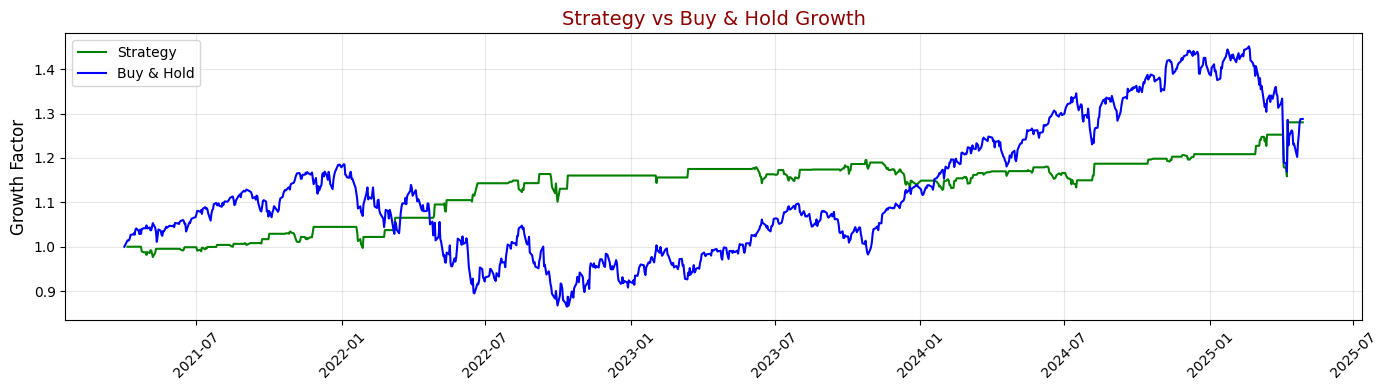

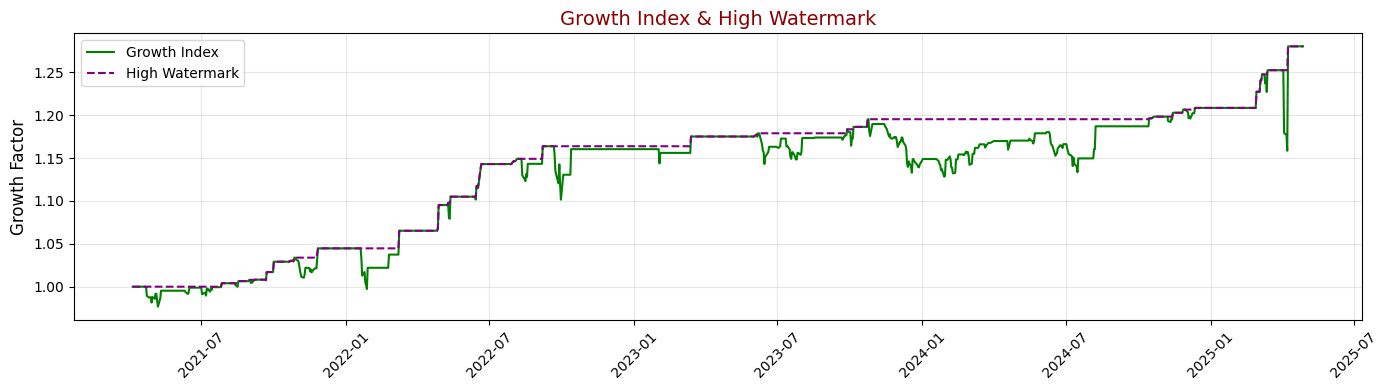

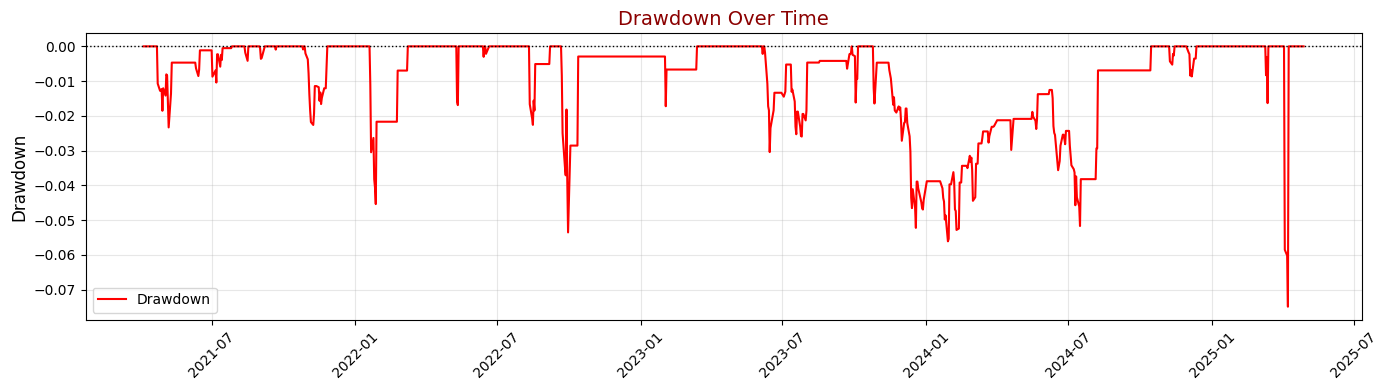

In [21]:
perf_RSI_SPY, metrics_RSI_SPY = strategy_performance(RSI_SPY, trading_days=252, plot=True, pairs=False)

In [22]:
metrics_RSI_SPY

,Value
Strategy Cum Ret,0.280300
Annualized Return,0.060927
Annualized Std,0.087397
Annualized Sharpe,0.697133
Max Drawdown,-0.074939


## **2. Mean Reversion - Bollinger Bands**

In [24]:
def BB_strategy(df: pd.DataFrame, price_col: str = 'Close', window: int = 20, n_std: float = 2.0,
                plot: bool = False, plot_window: int | None = None) -> pd.DataFrame:

    df = df.copy()
    price = df[price_col]

    # 1) rolling mean and std
    df['ma'] = price.rolling(window, min_periods=window).mean()
    df['upper_bb'] = df['ma'] + n_std * price.rolling(window, min_periods=window).std()
    df['lower_bb'] = df['ma'] - n_std * price.rolling(window, min_periods=window).std()

    # 2) log returns
    df['returns'] = np.log(price / price.shift(1))

    # 3) signals
    df['signal'] = 0
    df.loc[price < df['lower_bb'], 'signal'] = 1
    df.loc[price > df['upper_bb'], 'signal'] = -1

    # 4) positions
    df['position'] = df['signal'].shift(1).fillna(0).astype(int)

    # 5) strategy returns
    df['strategy_ret'] = df['position'] * df['returns']

    # 6) plotting: price + bands + shaded positions
    if plot:
        data_to_plot = df if plot_window is None else df.tail(plot_window)
        fig, ax = plt.subplots(figsize=(12, 5))

        # price and bands
        ax.plot(data_to_plot.index, data_to_plot[price_col], label=price_col, color='black')
        ax.plot(data_to_plot.index, data_to_plot['ma'], label=f"MA({window})", linestyle='--', color='purple')
        ax.plot(data_to_plot.index, data_to_plot['upper_bb'], label=f"Upper BB", linestyle='--', lw = 1.2, color='royalblue')
        ax.plot(data_to_plot.index, data_to_plot['lower_bb'], label=f"Lower BB", linestyle='--', lw = 1.2, color='royalblue')
        
        # shaded positions
        ymin, ymax = data_to_plot[price_col].min(), data_to_plot[price_col].max()
        ax.fill_between(data_to_plot.index, ymin, ymax,
                        where=(data_to_plot['position'] > 0),
                        facecolor='green', alpha=0.2, label='Long')
        ax.fill_between(data_to_plot.index, ymin, ymax,
                        where=(data_to_plot['position'] < 0),
                        facecolor='red', alpha=0.2, label='Short')
        
        ax.set_title(f"{price_col} with Bollinger Bands ({window}, ±{n_std})")
        ax.set_ylabel("Price")
        ax.set_xlabel("Date")
        ax.legend(loc='upper left')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return df

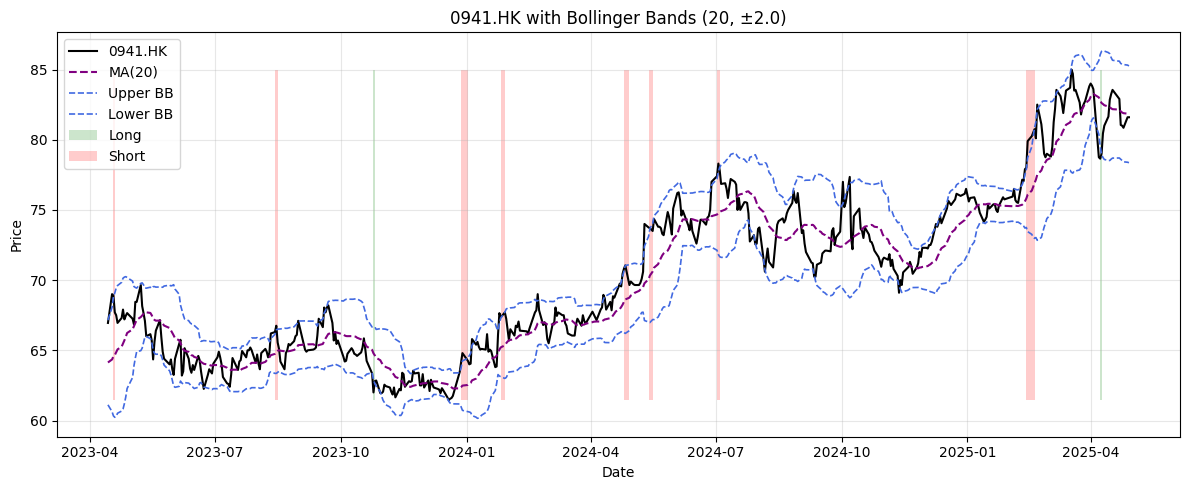

In [25]:
BB_0941HK = BB_strategy(Global_data[['0941.HK']].dropna(), price_col='0941.HK', window=20,n_std=2.0, 
                        plot=True, plot_window = 500)

In [26]:
BB_0941HK.tail(3)

Ticker,0941.HK,ma,upper_bb,lower_bb,returns,signal,position,strategy_ret
Date,,,,,,,,
2025-04-25,80.849998,81.890001,85.353130,78.426871,-0.001854,0,0,-0.0
2025-04-28,81.599998,81.855000,85.314830,78.395170,0.009234,0,0,0.0
2025-04-29,81.599998,81.807500,85.253211,78.361789,0.000000,0,0,0.0


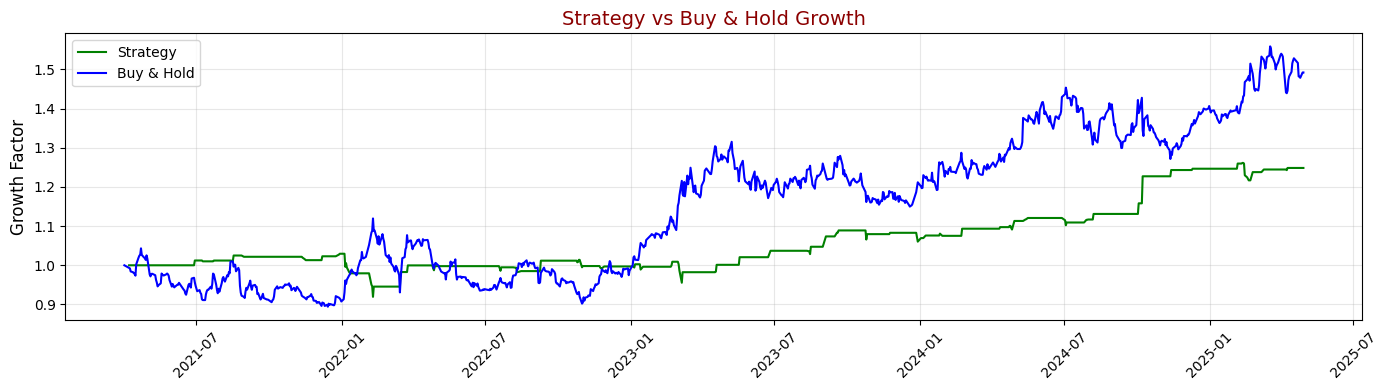

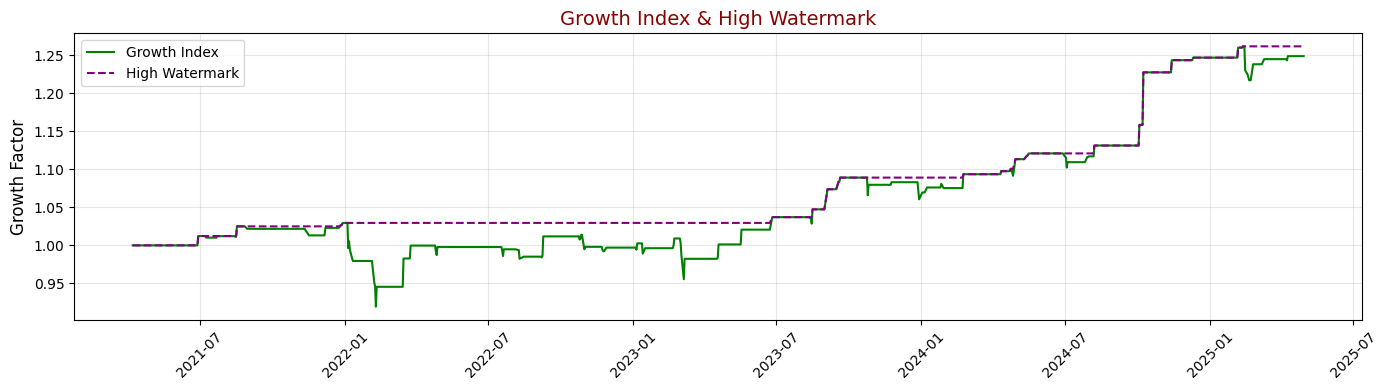

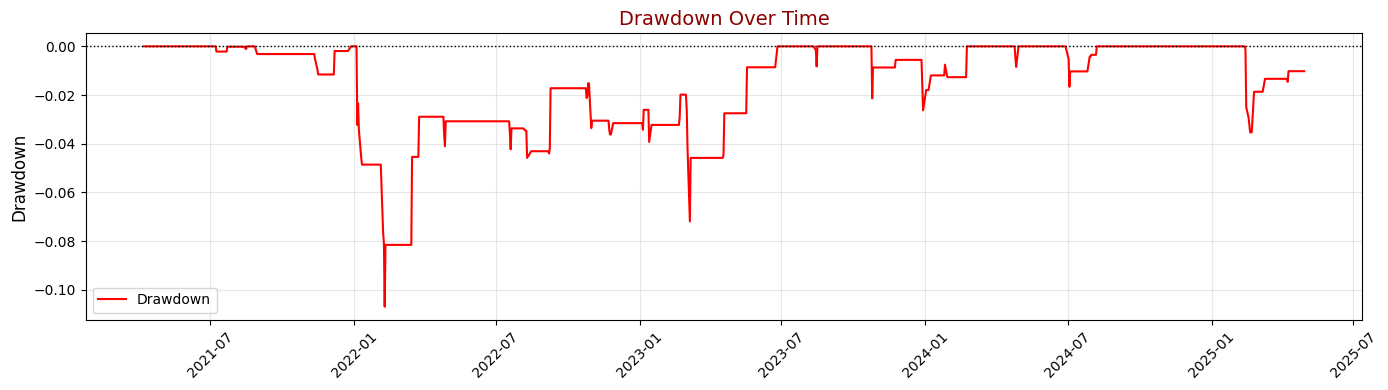

In [27]:
perf_BB_0941HK, metrics_BB_0941HK = strategy_performance(BB_0941HK, trading_days=252, plot=True, pairs=False)

In [28]:
metrics_BB_0941HK

,Value
Strategy Cum Ret,0.248516
Annualized Return,0.056045
Annualized Std,0.070520
Annualized Sharpe,0.794738
Max Drawdown,-0.106898


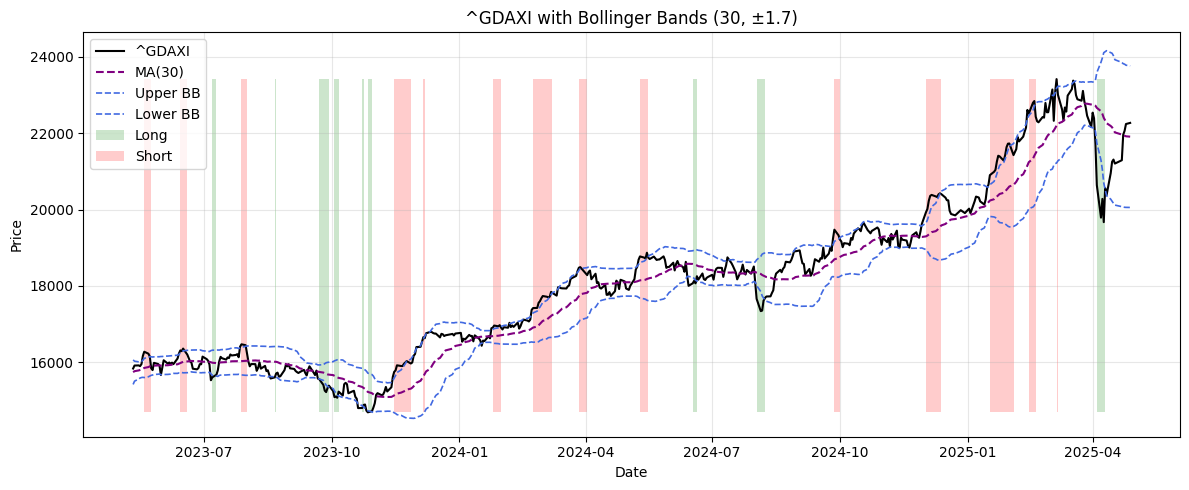

In [29]:
BB_GDAXI = BB_strategy(Global_data[['^GDAXI']].dropna(), price_col='^GDAXI', window=30,n_std=1.7, 
                       plot=True, plot_window = 500)

In [30]:
BB_GDAXI.tail(3)

Ticker,^GDAXI,ma,upper_bb,lower_bb,returns,signal,position,strategy_ret
Date,,,,,,,,
2025-04-24,22064.509766,21935.423307,23810.710593,20060.136022,0.004658,0,0,0.0
2025-04-25,22242.449219,21920.957943,23783.953915,20057.961970,0.008032,0,0,0.0
2025-04-28,22271.669922,21911.108919,23766.131895,20056.085944,0.001313,0,0,0.0


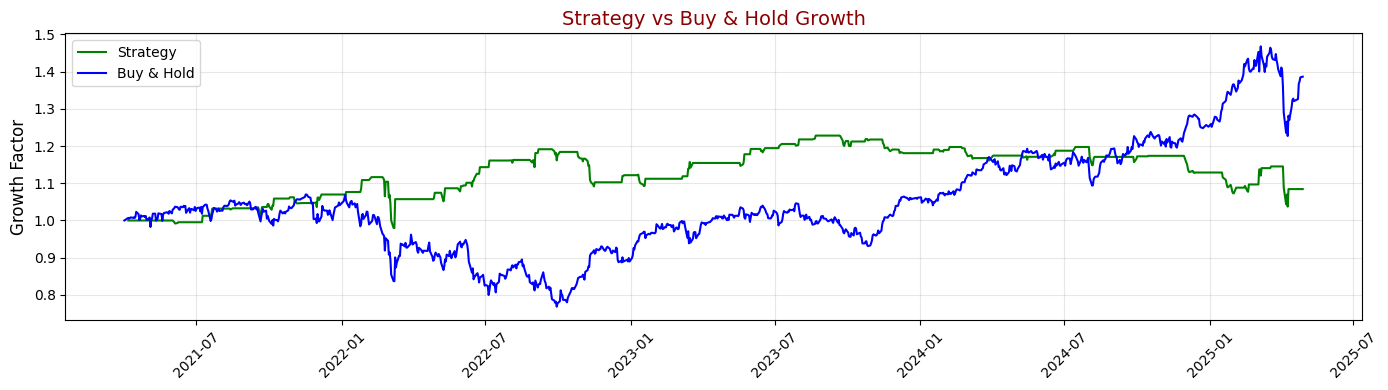

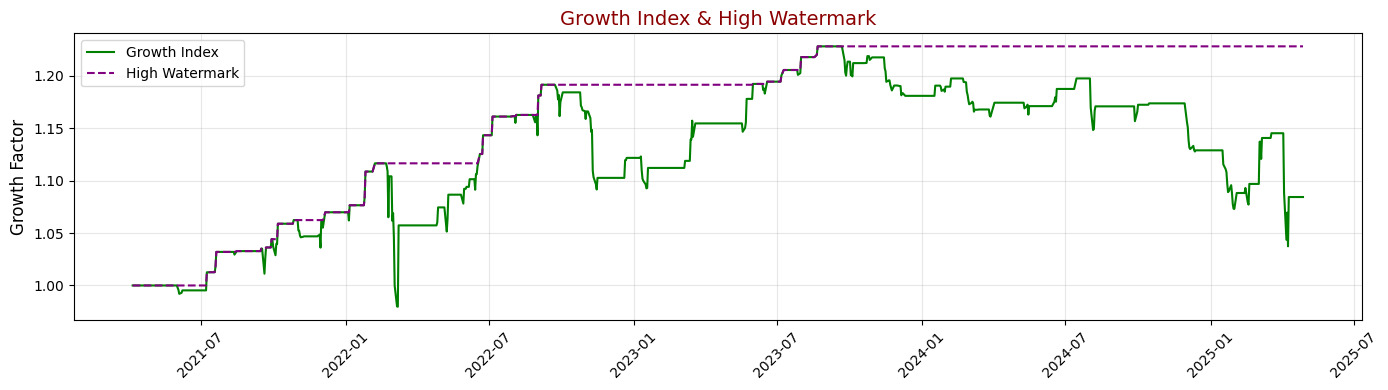

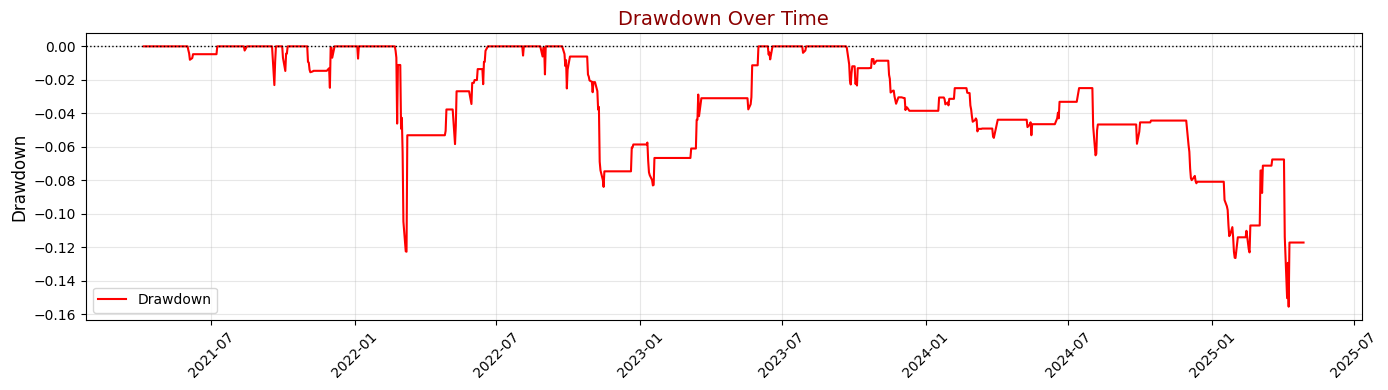

In [31]:
perf_BB_GDAXI, metrics_BB_GDAXI = strategy_performance(BB_GDAXI, trading_days=252, plot=True, pairs=False)

In [32]:
metrics_BB_GDAXI

,Value
Strategy Cum Ret,0.084411
Annualized Return,0.019674
Annualized Std,0.099180
Annualized Sharpe,0.198365
Max Drawdown,-0.155376


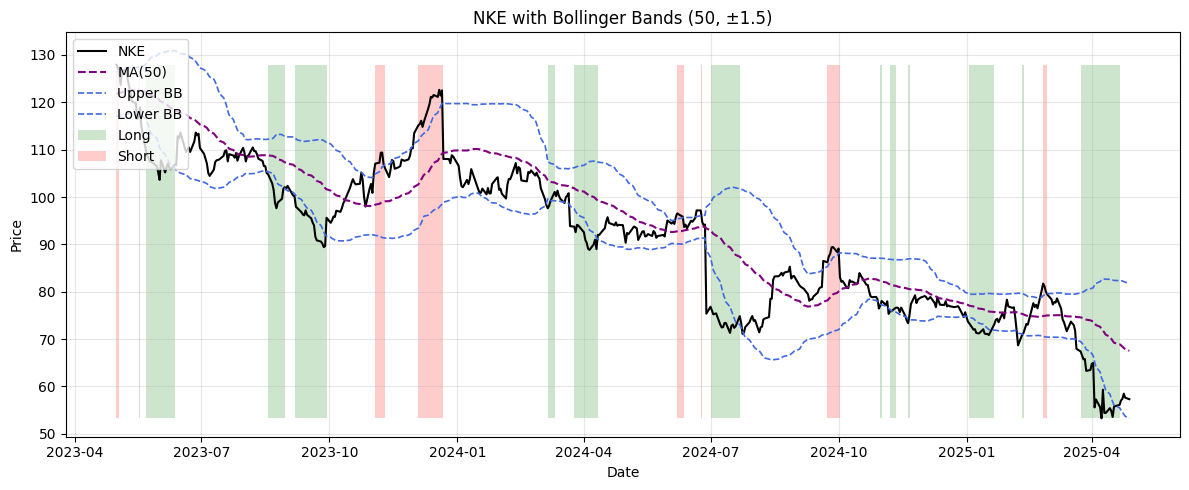

In [33]:
BB_NKE = BB_strategy(Global_data[['NKE']].dropna(), price_col='NKE', window=50,n_std= 1.5, 
                     plot=True, plot_window = 500)

In [34]:
BB_NKE.tail(3)

Ticker,NKE,ma,upper_bb,lower_bb,returns,signal,position,strategy_ret
Date,,,,,,,,
2025-04-24,58.480000,68.1540,82.159727,54.148273,0.018815,0,0,0.0
2025-04-25,57.619999,67.8612,82.013399,53.709001,-0.014815,0,0,-0.0
2025-04-28,57.310001,67.5432,81.820835,53.265565,-0.005395,0,0,-0.0


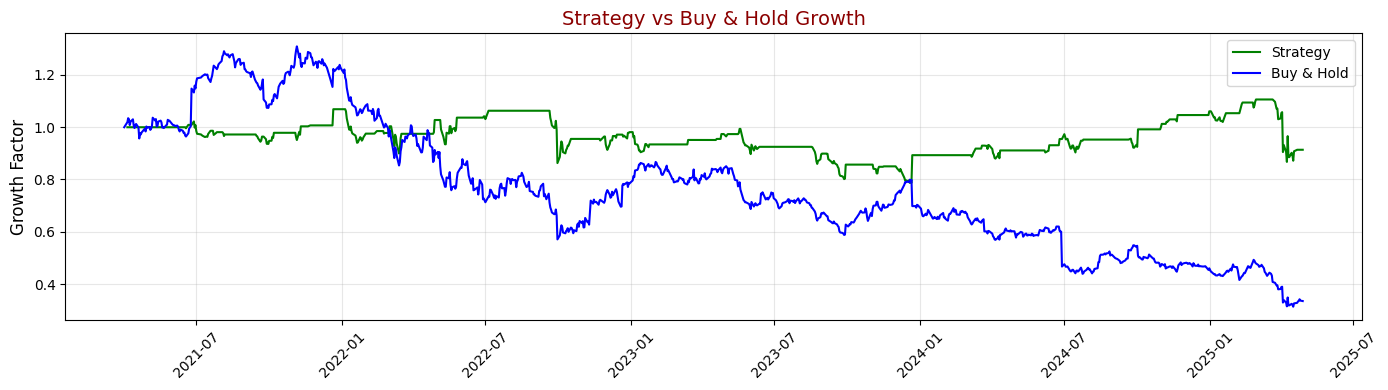

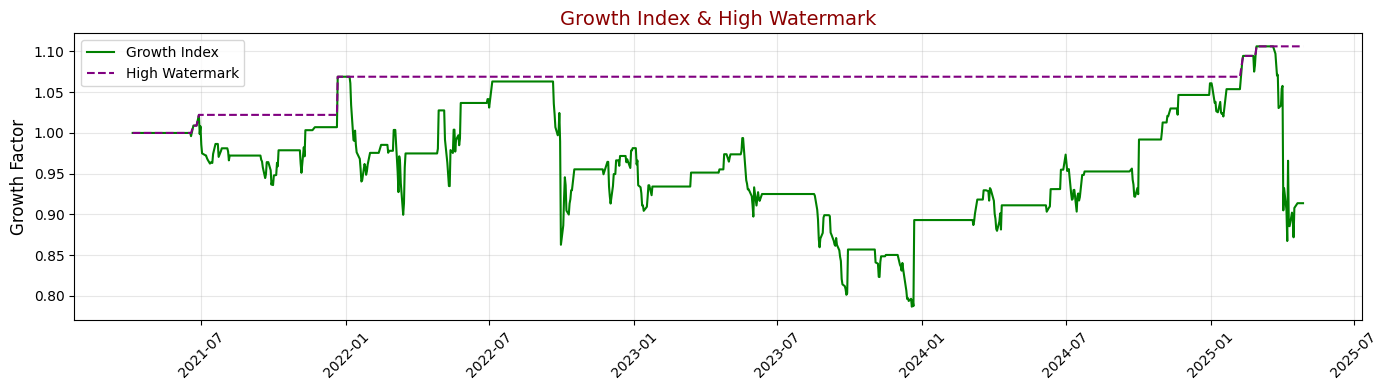

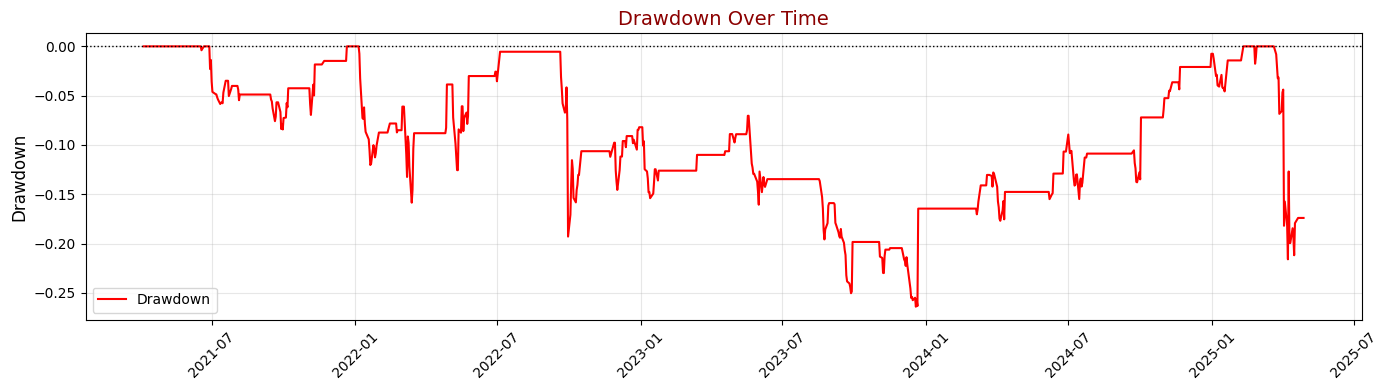

In [35]:
perf_BB_NKE, metrics_BB_NKE = strategy_performance(BB_NKE, trading_days=252, plot=True, pairs=False)

In [36]:
metrics_BB_NKE

,Value
Strategy Cum Ret,-0.086201
Annualized Return,-0.022227
Annualized Std,0.208553
Annualized Sharpe,-0.106579
Max Drawdown,-0.263979


## **3. Pairs Trading**

In [38]:
Crypto_data

Ticker,ADA-USD,BTC-USD,DOT-USD,ETH-USD,LTC-USD,SOL-USD,XRP-USD
Date,,,,,,,
2021-04-01,1.189244,59095.808594,37.672878,1977.276855,204.112518,19.084902,0.579292
2021-04-02,1.196509,59384.312500,41.164284,2143.225586,213.228394,19.810223,0.616569
2021-04-03,1.173277,57603.890625,41.646030,2028.422485,197.148209,22.552277,0.590915
2021-04-04,1.191420,58758.554688,44.652210,2093.122803,204.042908,24.061323,0.646729
2021-04-05,1.214300,59057.878906,45.797230,2107.887207,221.069046,22.984283,0.920473
...,...,...,...,...,...,...,...
2025-04-24,0.721827,93943.796875,4.264550,1769.831665,84.331688,152.303635,2.204544
2025-04-25,0.714141,94720.500000,4.255543,1786.634521,86.328041,150.915009,2.183054
2025-04-26,0.707521,94646.929688,4.267285,1821.881104,87.106789,149.289368,2.193189


In [39]:
# OLS regression and extract the residuals
def LinReg_OLS(x: pd.Series, y: pd.Series, plot: bool = True, title: str = None, return_residual: bool = False):

    # align & drop missing
    x_clean, y_clean = x.align(y, join='inner')
    mask = x_clean.notna() & y_clean.notna()
    x_clean, y_clean = x_clean[mask], y_clean[mask]

    # fit
    X = sm.add_constant(x_clean)
    model = sm.OLS(y_clean, X).fit()

    # predictions + residuals
    yhat = model.predict(X)
    residuals = y_clean - yhat

    if plot:
        fig, ax = plt.subplots(figsize=(8,4), dpi=120)
        ax.scatter(x_clean, y_clean, alpha=0.7)
        ax.plot(x_clean, yhat, lw=1.5, label='Regression Line', color = 'purple')

        # eq text
        b, w = model.params['const'], model.params[x.name]
        eq = rf"$\hat{{{y.name}}} = {b:.3f} + {w:.3f}\,{x.name}$"
        ax.text(0.05, 0.95, eq,
                transform=ax.transAxes,
                va='top', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

        ax.set_title(title or f"{y.name} vs {x.name}", color = 'darkred')
        ax.set_xlabel(x.name, color = 'darkblue')
        ax.set_ylabel(y.name, color = 'darkblue')
        ax.legend()
        ax.grid(alpha=0.3)
        plt.show()

    if return_residual:
        return model, residuals
    return model


# Cointegration test (test stationarity of the residuals)
from statsmodels.tsa.stattools import adfuller

def Cointegration_test(residuals: pd.Series, maxlag: int = None, regression: str = 'c', 
                       autolag: str = 'AIC', significance: float = 0.05) -> dict:

    # drop missing
    resid = residuals.dropna()
    adf_res = adfuller(resid, maxlag=maxlag, regression=regression, autolag=autolag)

    adf_stat, p_value, used_lag, nobs, crit_vals, icbest = adf_res

    return {
        'adf_stat':    adf_stat,
        'p_value':     p_value,
        'used_lag':    used_lag,
        'nobs':        nobs,
        'crit_values': crit_vals,
        'is_stationary': p_value < significance
    }

In [40]:
class PairsTrading:
    def __init__(
        self, 
        price_df: pd.DataFrame, maxlag: int = None, regression: str = 'c',
        autolag: str = 'AIC',significance: float = 0.05):

        self.price_df    = price_df
        self.maxlag      = maxlag
        self.regression  = regression
        self.autolag     = autolag
        self.significance= significance

        self.coint_df = None
        self.hedge_df = None

# =========================================================================================================
# PART 1. RUN COINTEGRATION TEST FOR ALL PAIRS BY RUNNING OLS FOR ALL PAIRS AND TEST STATIONARITY OF THE RESIDUALS
    
    def cointegration_test_mult(self) -> pd.DataFrame:
        """
        Apply Cointegration test for multiple pairs
        """
        results = []
        for a, b in itertools.combinations(self.price_df.columns, 2):
            # regress y=a on x=b
            _, resid = LinReg_OLS(x=self.price_df[b], y=self.price_df[a],
                                  plot=False,return_residual=True)
            
            test = Cointegration_test(residuals=resid, maxlag=self.maxlag, regression=self.regression,
                                      autolag=self.autolag, significance=self.significance)
            
            results.append({
                'asset1 (y)': a,
                'asset2 (x)': b,
                'adf_stat':   test['adf_stat'],
                'p_value':    test['p_value'],
                'used_lag':   test['used_lag'],
                'is_coint':   test['is_stationary']
            })

        self.coint_df = (pd.DataFrame(results)
                         .sort_values('p_value')
                         .reset_index(drop=True))
        
        return self.coint_df

    def hedge_ratio_calc(self) -> pd.DataFrame:
        """
        Calculate the hedge ratio (bascially the weight of the OLS regression).
        """
        if self.coint_df is None:
            raise ValueError("Run cointegration_test_mult() first")

        hedge_results = []
        for _, row in self.coint_df[self.coint_df.is_coint].iterrows():
            a = row['asset1 (y)']
            b = row['asset2 (x)']
            # re-fit OLS a ~ b
            model, _ = LinReg_OLS(x=self.price_df[b],
                                  y=self.price_df[a],
                                  plot=False, return_residual=True)
            
            # slope on x=b is model.params[b]
            hedge_ratio = model.params[b]
            hedge_results.append({'asset1 (y)':  a,
                                  'asset2 (x)':  b,
                                  'hedge_ratio': hedge_ratio
                                 })

        self.hedge_df = pd.DataFrame(hedge_results).reset_index(drop=True)
        
        return self.hedge_df

    def plot_cointegrated(self, top_n: int = None):
        """
        OPTIONAL: in cases if we need to see the Regression plots of the cointegrated pairs.
        """
        if self.coint_df is None:
            raise ValueError("Run cointegration_test_mult() first")
        df = self.coint_df[self.coint_df.is_coint]
        if top_n is not None:
            df = df.head(top_n)

        for _, row in df.iterrows():
            a, b = row['asset1 (y)'], row['asset2 (x)']
            LinReg_OLS(x=self.price_df[b], y=self.price_df[a], plot=True, title=f"{a} vs {b}")

    def get_spreads(self) -> pd.DataFrame:
        """
        Compute the residual spread series for each cointegrated pair:
          spread_t = y_t - hedge_ratio * x_t
        """
        # make sure we have hedge ratios
        if self.hedge_df is None:
            self.hedge_ratio_calc()

        spreads = {}
        for _, row in self.hedge_df.iterrows():
            a = row['asset1 (y)']
            b = row['asset2 (x)']
            beta = row['hedge_ratio']

            # align the two series
            sa, sb = self.price_df[a].align(self.price_df[b], join='inner')
            sa, sb = sa.dropna(), sb.dropna()

            # compute spread = y (a) minus beta * x (b)
            spread = sa - beta * sb
            spreads[f"{a}_{b}"] = spread

        # combine into a single DataFrame
        return pd.DataFrame(spreads)

# =========================================================================================================
# PART 2. NORMALIZE THE SPREAD, GENERATING THE SIGNALS, THEN SHIFT THE SIGNALS
    
    def get_pair_df(self,
                    asset1: str, asset2: str, rolling_windows: list[int] | None = None) -> pd.DataFrame:
        """
        Return a DataFrame with columns [asset1, asset2, spread]
        and, if rolling_windows is given, rolling‐z columns for each window.

        """
        # 1) get raw price + spread
        pair_col = f"{asset1}_{asset2}"
        spreads = self.get_spreads()
        if pair_col not in spreads:
            raise KeyError(f"No spread for pair {pair_col}")
        s1 = self.price_df[asset1].rename(asset1)
        s2 = self.price_df[asset2].rename(asset2)
        sp = spreads[pair_col].rename('spread')

        # 2) align and drop NaNs
        df = pd.concat([s1, s2, sp], axis=1).dropna()

        # 3) optional rolling z-scores
        if rolling_windows:
            for w in rolling_windows:
                # rolling mean/std
                mu = df['spread'].rolling(window=w).mean()
                sigma = df['spread'].rolling(window=w).std()
                df[f"z_{w}"] = (df['spread'] - mu) / sigma

        return df


    def generate_pair_signals_positions(self,
                                        asset1: str, asset2: str, z_window: int, 
                                        entry_z: float = 2.0, exit_z: float = 0.5) -> pd.DataFrame:
        """
        1) Calls get_pair_df(asset1, asset2, rolling_windows=[z_window])
        2) Builds `signal_pair`, forward-fills it in a long_short style
        3) Creates `signal_<asset1>`, `signal_<asset2>`
        4) Shifts for `position_<asset1>`, `position_<asset2>`
        """
        # 1) Grab prices, spread and z_{z_window}
        df = self.get_pair_df(
            asset1, asset2,
            rolling_windows=[z_window]
        )
        z_col = f"z_{z_window}"
        spread = df['spread']
        z      = df[z_col]

        # 2) raw spread signal
        sig = pd.Series(0, index=df.index, name='signal_pair')
        sig[z >  entry_z] = -1
        sig[z < -entry_z] = +1

        # long_short‐style zero‐and‐ffill
        flip = ((sig.shift(1)>0)&(sig<0)) | ((sig.shift(1)<0)&(sig>0))
        sig[flip] = 0
        sig = sig.replace(0, np.nan).ffill().fillna(0).astype(int)

        # 3) per-asset signals
        sig_y = sig.rename(f"signal_{asset1}")
        sig_x = (-sig).rename(f"signal_{asset2}")

        # 4) next-day positions
        pos_y = sig_y.shift(1).fillna(0).astype(int).rename(f"position_{asset1}")
        pos_x = sig_x.shift(1).fillna(0).astype(int).rename(f"position_{asset2}")

        return pd.concat(
            [spread.rename('spread'), z.rename(z_col), sig, sig_y, sig_x, pos_y, pos_x],
            axis=1)

# =========================================================================================================
# PART 3. CALCULATE THE RETURN OF THE PAIR TRADING STRATEGIES FOR 2 CASES: 1) USING THE HEDGE RATIO; 2) USING A RATIO OF 1:1
    
    def pair_return(self,
                    asset1: str, asset2: str, z_window: int, entry_z: float = 2.0, exit_z: float = 0.5,
                    use_hedge: bool = True) -> pd.DataFrame:

        # 1) signals & positions (uses log‐prices internally)
        sig_df = self.generate_pair_signals_positions(
            asset1, asset2, z_window, entry_z, exit_z)

        # 2) log‐returns
        prices = self.price_df[[asset1, asset2]]
        log_ret = np.log(prices / prices.shift(1)).rename(
            columns={asset1: 'r1', asset2: 'r2'})

        # 3) pick hedge ratio
        if use_hedge:
            β = self.hedge_df.query(
                "(`asset1 (y)`==@asset1)&(`asset2 (x)`==@asset2)")['hedge_ratio'].item()
        else:
            β = 1.0

        # 4) assemble and compute PnL
        df = pd.concat([sig_df, log_ret], axis=1).dropna()
        pos_y = df[f"position_{asset1}"]
        pos_x = df[f"position_{asset2}"]

        # strategy return: pos_y * r1 + pos_x * (β * r2)
        # since pos_x == -pos_y, it's additive across days
        df['strategy_ret'] = pos_y * df['r1'] + pos_x * (β * df['r2'])

        return df

### 3.1. Test on a single case

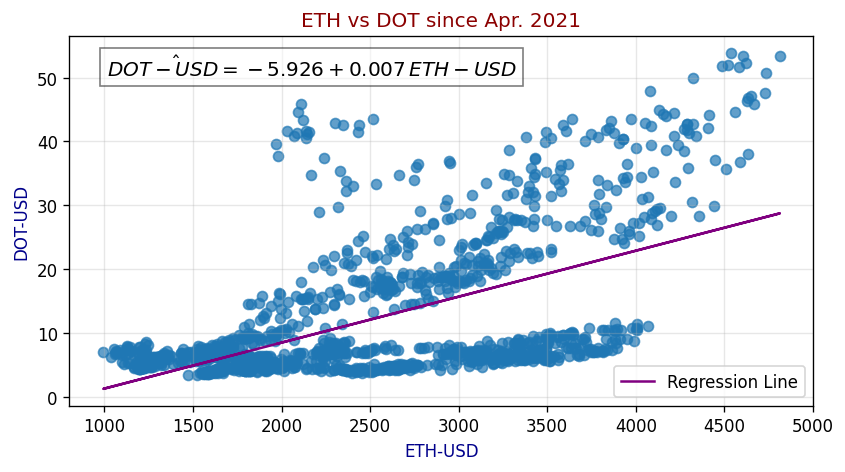

In [42]:
# Try a random pair
OLS, res =  (
    LinReg_OLS(Crypto_data['ETH-USD'], Crypto_data['DOT-USD'],
               plot = True, title = 'ETH vs DOT since Apr. 2021', return_residual = True)
)

In [43]:
res

Date
2021-04-01    29.360315
2021-04-02    31.656727
2021-04-03    32.965168
2021-04-04    35.505442
2021-04-05    36.544144
                ...    
2025-04-24    -2.554204
2025-04-25    -2.684208
2025-04-26    -2.926277
2025-04-27    -2.888997
2025-04-29    -2.760940
Length: 1489, dtype: float64

In [44]:
# Cointegration test = ADF test of the residual
Cointegration_test(res, regression='c', autolag='AIC', maxlag=None)

{'adf_stat': -2.9020511773142466,
 'p_value': 0.04510999286603628,
 'used_lag': 20,
 'nobs': 1468,
 'crit_values': {'1%': -3.434812378381713,
  '5%': -2.863510846577674,
  '10%': -2.5678192598690317},
 'is_stationary': True}

### 3.2. Pairs Trading on a batch

In [46]:
# Create the object Pairs Trading (PT)
PT = PairsTrading(Crypto_data)

In [47]:
coint_df = PT.cointegration_test_mult()   # run batch ADF TEST
hedge_df = PT.hedge_ratio_calc()          # get hedge ratios for cointegrated pairs

In [48]:
coint_df[coint_df.is_coint]

# Display cointegrated pairs

,asset1 (y),asset2 (x),adf_stat,p_value,used_lag,is_coint
0,ADA-USD,LTC-USD,-3.814243,0.002765,13,True
1,ADA-USD,DOT-USD,-3.674531,0.004486,19,True
2,LTC-USD,SOL-USD,-3.435143,0.009818,21,True
3,DOT-USD,SOL-USD,-3.132639,0.024230,15,True
4,DOT-USD,ETH-USD,-2.902051,0.045110,20,True


In [49]:
# Display hedge ratio of cointegrated pairs

hedge_df

,asset1 (y),asset2 (x),hedge_ratio
0,ADA-USD,LTC-USD,0.008935
1,ADA-USD,DOT-USD,0.045189
2,LTC-USD,SOL-USD,0.150360
3,DOT-USD,SOL-USD,0.035592
4,DOT-USD,ETH-USD,0.007201


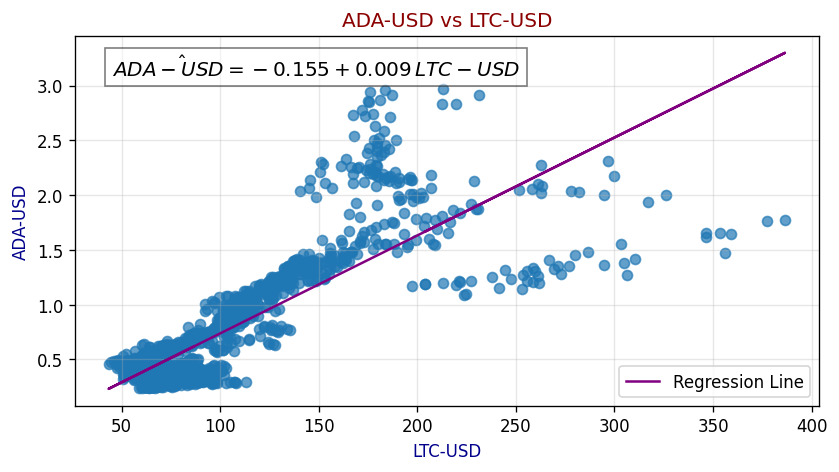

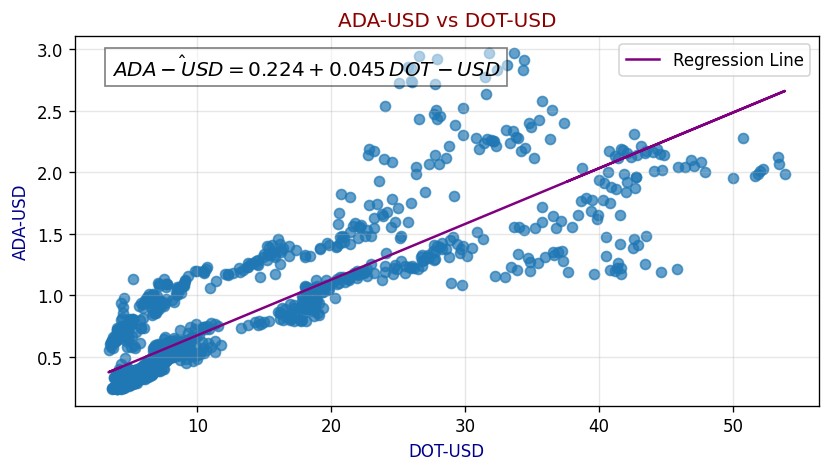

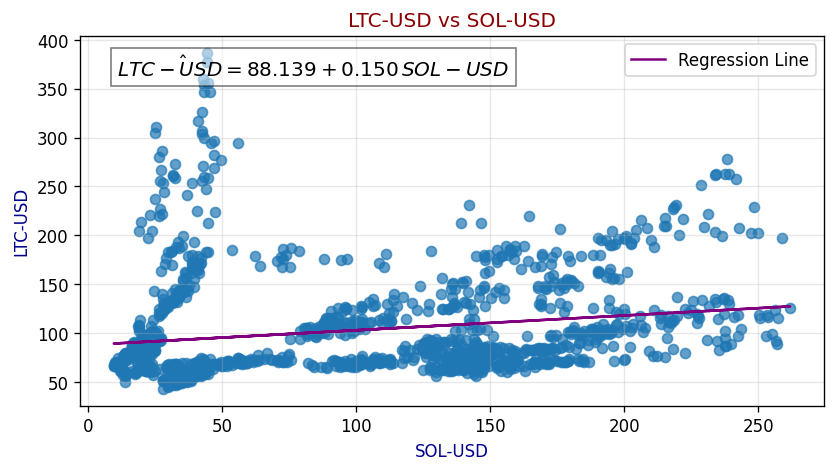

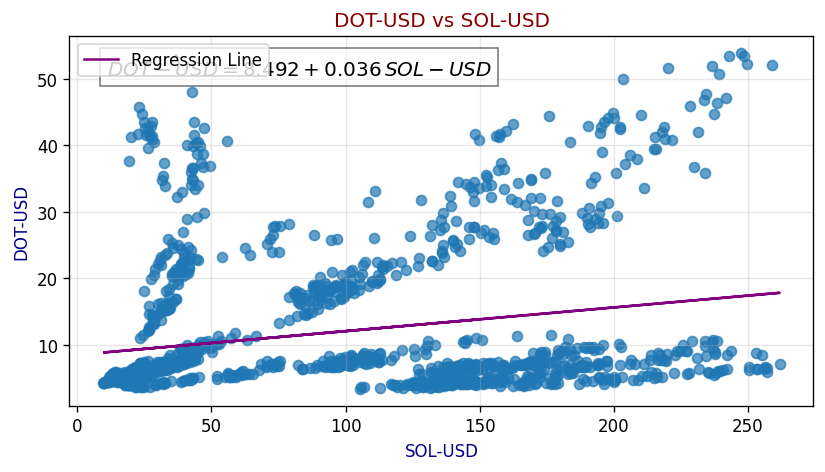

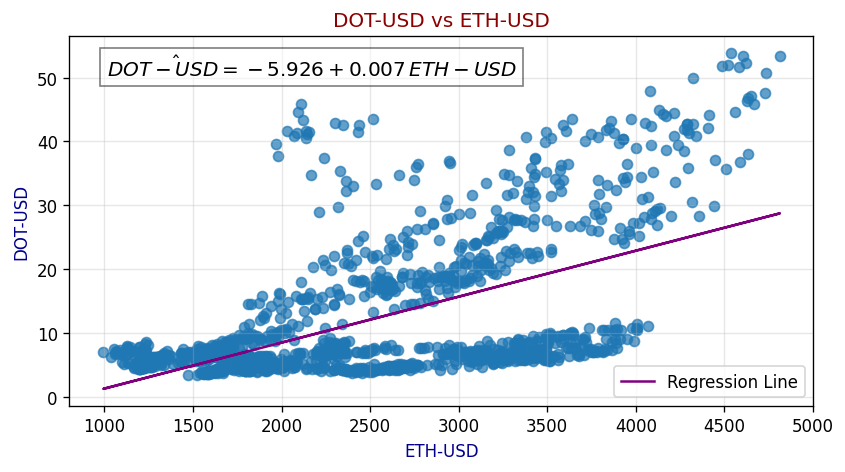

In [50]:
PT.plot_cointegrated(top_n=5)

In [51]:
# This line is optional. It is a part of the class but not needed to be run
# Just call for sanity check of the spread of the cointegrated pairs

spread_df = PT.get_spreads() 

In [52]:
spread_df

,ADA-USD_LTC-USD,ADA-USD_DOT-USD,LTC-USD_SOL-USD,DOT-USD_SOL-USD,DOT-USD_ETH-USD
Date,,,,,
2021-04-01,-0.634596,-0.513160,201.242921,36.993615,23.434545
2021-04-02,-0.708785,-0.663669,210.249738,40.459205,25.730957
2021-04-03,-0.588333,-0.708671,193.757259,40.843357,27.039398
2021-04-04,-0.631798,-0.826374,200.425058,43.795828,29.579672
2021-04-05,-0.761054,-0.855237,217.613140,44.979181,30.618374
...,...,...,...,...,...
2025-04-24,-0.031716,0.529116,61.431383,-1.156190,-8.479974
2025-04-25,-0.057240,0.521837,63.636530,-1.115774,-8.609978
2025-04-26,-0.070818,0.514686,64.659708,-1.046173,-8.852047


#### Strategy Return Calculation

Let:
- $y$ = asset1 price, with log‐return $r_{y,t}$
- $x$ = asset2 price, with log‐return $r_{x,t}$  
- $\beta$ = hedge ratio (OLS slope), or $\beta=1$ when using a 1:1 ratio  
- $\mathrm{pos}_{y,t}\in\{+1,0,-1\}$ = next‐day position in $y$ 
- $\mathrm{pos}_{x,t} = -\,\mathrm{pos}_{y,t}$ = next‐day position in $x$

Then the strategy log‐return on day $t$ is  
$$
\mathrm{strategy\_ret}_t 
= \mathrm{pos}_{y,t}\,r_{y,t}
\;+\;\mathrm{pos}_{x,t}\,\bigl(\beta\,r_{x,t}\bigr)
$$

In [54]:
# Suppose that I pick the pair ADA-USD and DOT-USD

# The parameters entry_z and exit_z are subjected to optimization
res_with_hedge = PT.pair_return('ADA-USD','DOT-USD', z_window=365, entry_z=3, exit_z=0.5, use_hedge=True)

# backtest with a 1:1 hedge instead
res_flat_hedge = PT.pair_return('ADA-USD','DOT-USD', z_window=365, entry_z=3, exit_z=0.5, use_hedge=False)

In [55]:
res_with_hedge

,spread,z_365,signal_pair,signal_ADA-USD,signal_DOT-USD,position_ADA-USD,position_DOT-USD,r1,r2,strategy_ret
Date,,,,,,,,,,
2022-03-31,0.179209,-0.276845,0,0,0,0,0,-0.041626,-0.053283,-0.000000
2022-04-01,0.170497,-0.300286,0,0,0,0,0,0.020435,0.032989,0.000000
2022-04-02,0.132720,-0.386744,0,0,0,0,0,-0.008114,0.028104,0.000000
2022-04-03,0.137181,-0.384627,0,0,0,0,0,0.025565,0.024589,0.000000
2022-04-04,0.189060,-0.282125,0,0,0,0,0,0.022515,-0.024005,0.000000
...,...,...,...,...,...,...,...,...,...,...
2025-04-24,0.529116,0.823141,-1,-1,1,-1,1,0.034188,0.041020,-0.032335
2025-04-25,0.521837,0.786786,-1,-1,1,-1,1,-0.010705,-0.002114,0.010609
2025-04-26,0.514686,0.751127,-1,-1,1,-1,1,-0.009313,0.002755,0.009438


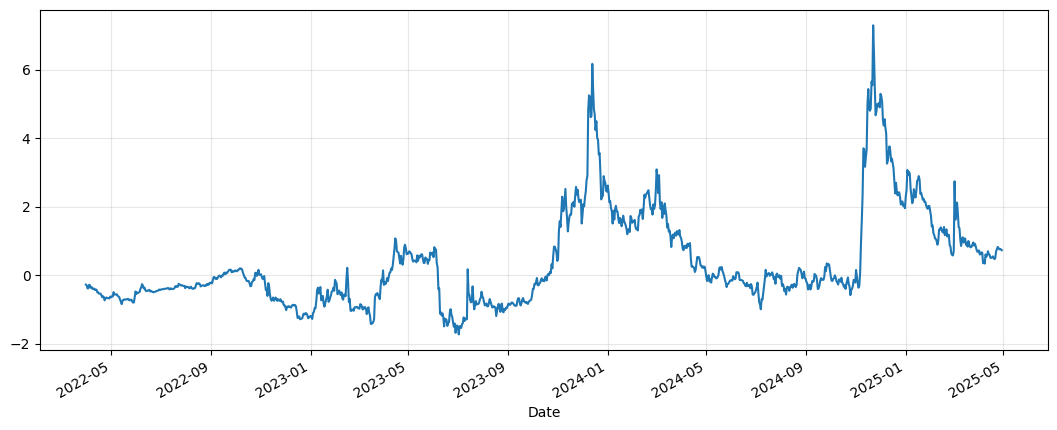

In [56]:
# We plot the normalize z over recent 1 year to see if the spread indicates cointegration
res_with_hedge.z_365.plot(figsize = (13,5))
plt.grid(alpha = 0.3);

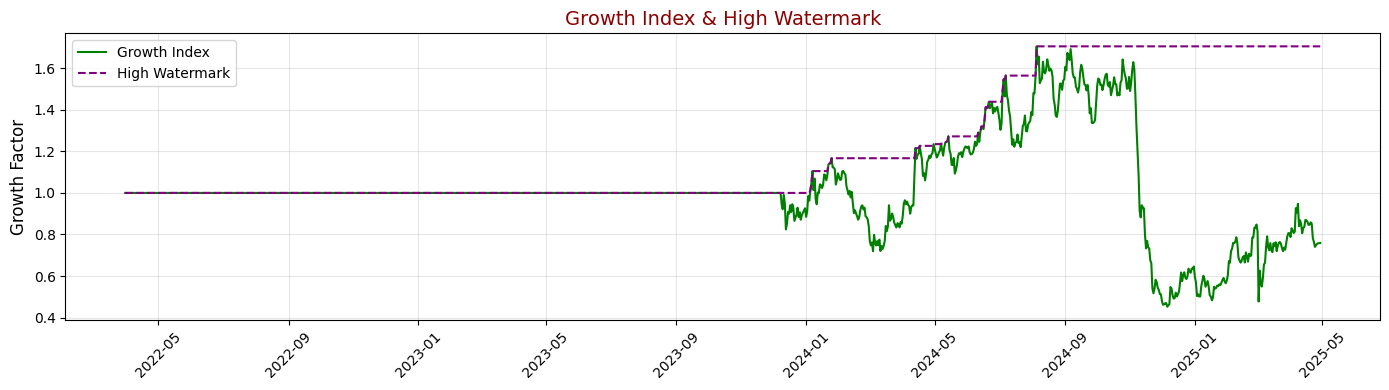

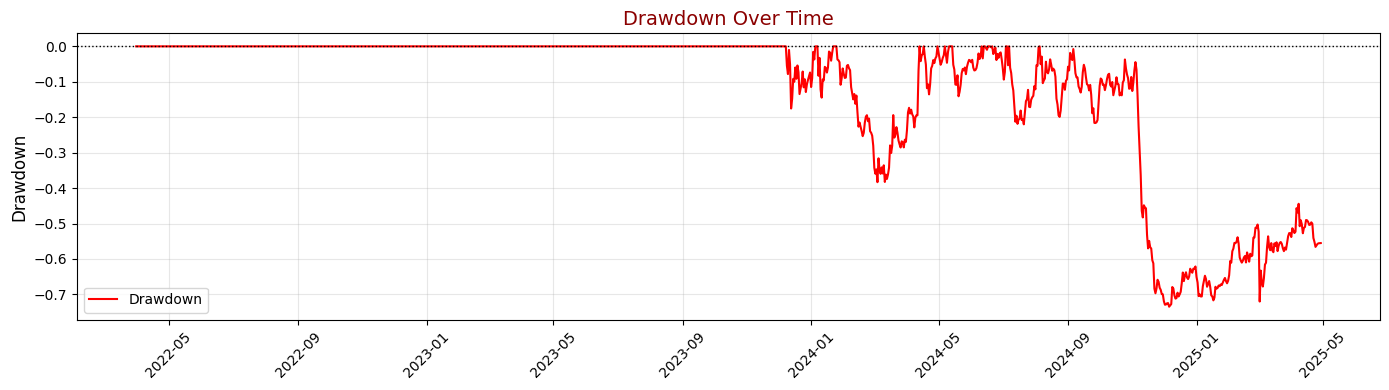

In [57]:
# Performance using beta = hedge ratio
perf_pairs_hedged, metrics_pairs_hedged = strategy_performance(res_with_hedge, trading_days=365, plot=True, pairs=True)

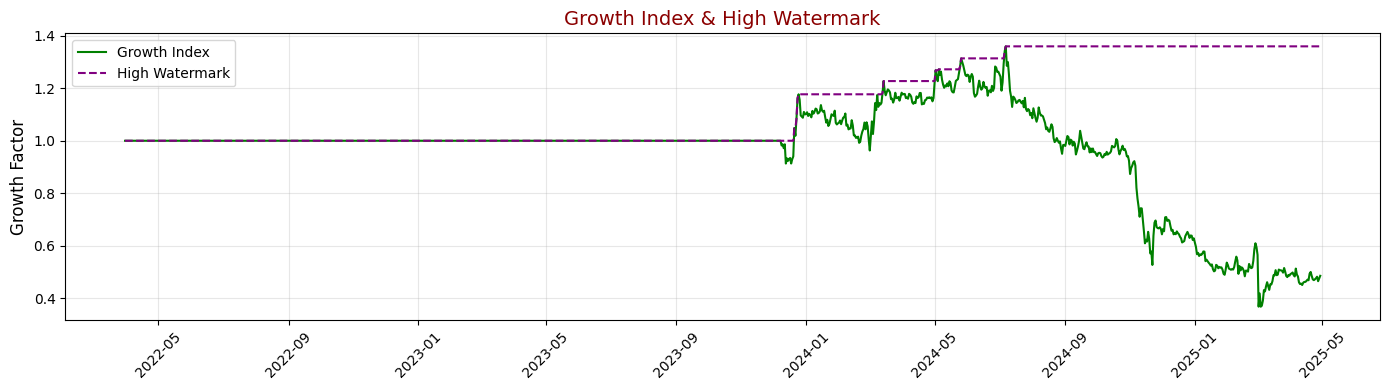

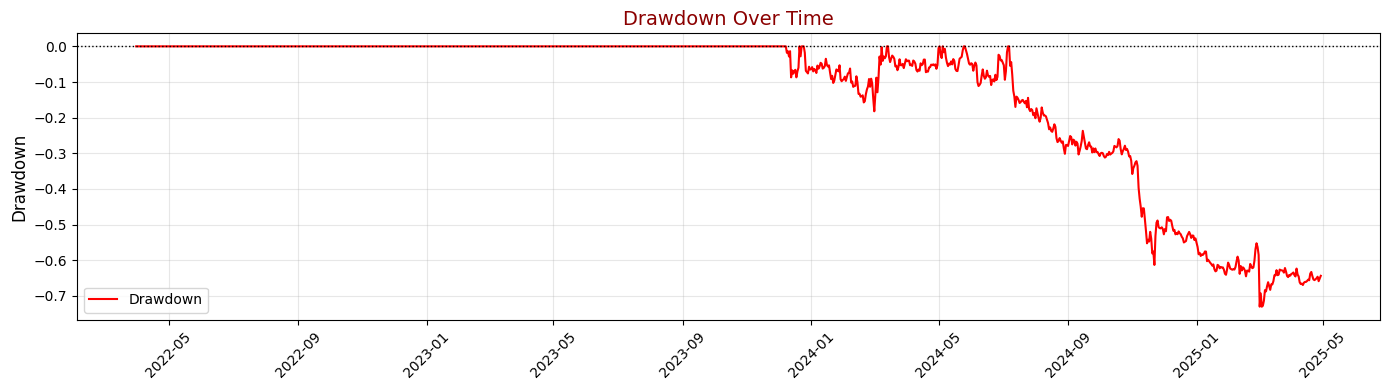

In [58]:
# Performance using beta = 1
perf_pairs_flat, metrics_pairs_flat = strategy_performance(res_flat_hedge, trading_days=365, plot=True, pairs=True)

## **4. Concatenate performance of all strategies on different assets**

In [60]:
metrics_all = pd.concat([
    metrics_SMA_AAPL,
    metrics_SMA_MSFT,
    metrics_RSI_SPY,
    metrics_BB_0941HK,
    metrics_BB_GDAXI,
    metrics_BB_NKE,
    metrics_pairs_hedged,
    metrics_pairs_flat
], axis = 1)

metrics_all.columns = ['SMA_AAPL', 'SMA_MSFT', 'RSI_SPY', 'BB_0941HK', 'BB_GDAXI', 'BB_NKE', 'Pairs_hedged', 'Pairs_flat']

In [61]:
metrics_all

,SMA_AAPL,SMA_MSFT,RSI_SPY,BB_0941HK,BB_GDAXI,BB_NKE,Pairs_hedged,Pairs_flat
Strategy Cum Ret,0.558273,-0.508944,0.280300,0.248516,0.084411,-0.086201,-0.241260,-0.515162
Annualized Return,0.109375,-0.175364,0.060927,0.056045,0.019674,-0.022227,-0.089578,-0.234878
Annualized Std,0.280775,0.265120,0.087397,0.070520,0.099180,0.208553,0.647301,0.440410
Annualized Sharpe,0.389548,-0.661451,0.697133,0.794738,0.198365,-0.106579,-0.138386,-0.533317
Max Drawdown,-0.219281,-0.634273,-0.074939,-0.106898,-0.155376,-0.263979,-0.734669,-0.730137
